In [1]:
import pandas as pd
import numpy as np
from selenium import webdriver
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use("ggplot")

In [2]:
import yfinance as yf

def daily_returns(data : pd.Series) -> float:
    '''
        Function to calculate daily returns from daliy price data
    '''
    return(data - data.shift(1))/data.shift(1)

def tracking_error(benchmark : pd.Series, portfolio : pd.Series) -> float:
    '''
        Function to compute tracking error
    '''
    return (portfolio - benchmark).std()

# Portfolio

In [3]:
class Portfolio:
    def __init__(self, target: str,
                tickerlist: list,
                investment: int = 1000,
                rebalance : int = 0,
                reconstitute : int = 1) -> None:
        '''
            Initialise portfolio
        '''
        self.target = target
        self.tickers = tickerlist
        # self.initFlag = True
        
        self.start_nav = investment
        self.prevday_nav = investment
        self.current_nav = investment
        self.dividents = np.array([0.0]*len(tickerlist))                  # ignore dividents for now
        self.returns = self.get_returns()
        
        self.weights = pd.Series([1]*len(tickerlist), index=tickerlist)   # Equally balanced portfolio. Should Contain number of stocks owned. Ideally, Whole Numbers
        self.last_rebalancing_date = pd.to_datetime("01-01-1990")         # First rebalancing at 01st, Jan
        self.rebalancing_interval = rebalance - 1                         # in month (plus 1, because that month included)
        self.last_reconstitution_date = pd.to_datetime("01-01-1990")      # First reconstitution at 01st, Jan
        self.reconstitution_interval = reconstitute                       # in years
        pass

    def isUpdateAllowed(self, date: pd.Timestamp, mode : str = "rebalance") -> bool:
        '''
            Calculate Number of months between two dates
        '''
        diff = False
        if mode == "rebalance":
            diff = (date.year - self.last_rebalancing_date.year)*12 + date.month - self.last_rebalancing_date.month
            diff = diff >= self.rebalancing_interval
        elif mode == "reconstitute":
            diff = (date.year - self.last_reconstitution_date.year)*12 + date.month - self.last_rebalancing_date.month
            diff = diff >= self.reconstitution_interval
        return diff

    def reconstitute(self, price, date = None) -> None:
        '''
            Function to Reconstitute our portfolio.
            Checks:
                - weights updated only after "Reconstitution" period has passed
        '''
        date = price.index[0] if date is None else date
        if self.isUpdateAllowed(date= date, mode="reconstitute"):
            self.last_reconstitution_date = date
            # Convert weights to number of shares in portfolio
            self.rebalance(weights=price)
        else:
            raise Exception("Reconstitution Interval not passed.\n\t\
                            Last Reconstituted on: {last_recons}\n\t\
                            Requesting Reconstitution on: {curr_recons}".format(last_recons = self.last_reconstitution_date.strftime("%d-%b-%Y"),
                                                                        curr_recons = date.strftime("%d-%b-%Y")))
        pass

    def rebalance(self, price, date: pd.Timestamp = None) -> None:
        '''
            Function to update the Number of shares held by our portfolio.
            Checks:
                - Do ticker lists match?
                - weights updated only after "rebalance" period has passed
        '''
        price = price.fillna(0)
        
        if self.isUpdateAllowed(date= date, mode="rebalance"):
            difference_set = {x for x in price.index if x not in set(self.tickers)}
            if len(difference_set) == 0:

                if self.target != "DJIA":
                    price["cap"] = price["shares"]*price["close"]
                    nav = sum(price["cap"])
                else:
                    price["cap"] = price["close"]
                    nav = sum(price["cap"])
                # Convert weights to number of shares in portfolio
                # First the current NAV is calculated at close of day, then the portfolio is rebalenced
                # if not self.initFlag:
                if self.last_rebalancing_date != pd.to_datetime("01-01-1990"):
                    self.prevday_nav = self.current_nav
                    self.current_nav = self.weights.multiply(price["close"]).sum()
                self.weights = (((price["cap"]/nav)*self.current_nav)/price["close"])
                self.last_rebalancing_date = date
                
                # self.weights = self.weights
                
                # self.initFlag = False
                # self.weights = np.array([weights[x][0] for x in self.tickers])
            else:
                raise Exception(" Input and Portfolio Tickers Not Matching. Net mismatch: {mismatch}\n".format(mismatch = len(difference_set))+", ".join(list(difference_set))); 
        else:
            raise Exception("rebalance Interval not passed.\n\t\
                            Last rebalanced on: {last_rebal}\n\t\
                            Requesting rebalance on: {curr_rebal}".format(last_rebal = self.last_rebalancing_date.strftime("%d-%b-%Y"),
                                                                        curr_rebal = date.strftime("%d-%b-%Y")))
        pass

    def net_return(self) -> float:
        return ((self.current_nav - self.start_nav + sum(self.dividents))/(self.start_nav))
        
    def get_returns(self) -> float:
        '''
        function to calculate returns of our portfolio
        '''
        return ((self.current_nav - self.prevday_nav + sum(self.dividents))/(self.prevday_nav))

    def echo(self) -> None:
        print("Target Index:",self.target)
        print("Starting Investment:",self.start_nav)
        print("Current Investment:",self.current_nav)
        print("Net Returns:", self.returns,"%")
        print("Constituent Indices:", ", ".join(self.tickers[0:5]+["\b\b ..."]))
        print("Constituent Weights:", self.weights[0:5])
        pass

# S&P 500 Replicating Portfolio

## Fetch S&P 500 Index Constituent Data

In [4]:
# # Create webdriver object
# webDriverLocation = '../../utils/chromedriver'
# driver = webdriver.Chrome(executable_path = webDriverLocation)

# # Get the website
# url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
# driver.get(url)

# def get_text(x):
#     return x.text

In [5]:
# xpath = '//*[@id="constituents"]/tbody/tr/td[1]'
# spy_ticker_set = set()
# for item in driver.find_elements_by_xpath(xpath=xpath):
#     spy_ticker_set.add(get_text(item))
# print(len(spy_ticker_set))
# # spy_ticker_set
# driver.close()

In [6]:
# with open('./data/spy_ticker.txt', 'w') as f:
#     for item in spy_ticker_set:
#         f.write("%s\n" % item)

## Read S&P 500 Index Constituent Data

In [7]:
spy_ticker_set = set()
with open('./data/spy_ticker.txt') as f:
    spy_ticker_set = f.readlines()
    spy_ticker_set = {x.strip() for x in spy_ticker_set}
print(len(spy_ticker_set))

505


Fetch data from WRDS using the  list

***

In [8]:
spy_portfolio = Portfolio(target="S&P 500",
                        tickerlist= list(spy_ticker_set), investment= 1000000,
                        rebalance=4, reconstitute=12)

spy_portfolio.echo()

Target Index: S&P 500
Starting Investment: 1000000
Current Investment: 1000000
Net Returns: 0.0 %
Constituent Indices: HOLX, MTB, CE, XYL, QRVO ...
Constituent Weights: HOLX    1
MTB     1
CE      1
XYL     1
QRVO    1
dtype: int64


## Read Daily Stock data from WRDS

### Desciption:

- GVKEY: Company Code ?
- IID  : Issue ID - Dividents ?
- DATADATE: Date
- TIC: Company Ticker
- CUSIP: Company CUSIP Code
- CONM : Company Name
- CSHOC : Shares Outstanding
- CSHTRD : Trading Volume
- PRCCD : Price Close Daily
- PRCHD : Price High Daily
- PRCLD : Price Low Daily
- PRCOD : Price Open Daily
- TRFD  : Total Return Factor Daily
- EXCHG : Stock Exchange Code
- BUSDESC : S&P Business Description
- GGROUP : GIC Groups
- GIND : GIC Industries
- GSECTOR : GIC Sector
- GSUBIND : GIC Sub-Industry

**Looking at stocks since 01 Jan 2010**

In [9]:
spy_dataframe = pd.read_csv("./data/spy_dataset.csv"
                    ,low_memory= False)
spy_dataframe["datadate"] = pd.to_datetime(spy_dataframe["datadate"])
spy_dataframe = spy_dataframe[spy_dataframe["tic"].apply(lambda x: (x in spy_ticker_set))]
spy_dataframe = spy_dataframe[spy_dataframe["datadate"] >= pd.to_datetime("01-01-2010")]
print("Number of unique tickers:",len(spy_dataframe.tic.value_counts()))
spy_data = spy_dataframe[["datadate","cshoc","tic","prccd"]].copy()\
                                                        .sort_values(by= "datadate")\
                                                        .rename({'cshoc':'shares',
                                                        #     'prchd':'high',
                                                        #     'prcld':'low',
                                                        #     'prcod':'open',
                                                                'prccd':'close',}, axis = 1).\
                                                        reset_index(drop=True)
print("Dimensions: ",spy_data.shape)
print(spy_data.isna().sum())
spy_data[np.isnan(spy_data.close)]

Number of unique tickers: 505
Dimensions:  (1428608, 4)
datadate      0
shares      115
tic           0
close         9
dtype: int64


,datadate,shares,tic,close
323951,2012-10-29,NaN,AOS,NaN
323952,2012-10-29,NaN,LNT,NaN
323953,2012-10-29,NaN,KMI,NaN
323954,2012-10-29,NaN,NI,NaN
323955,2012-10-29,NaN,MS,NaN
323956,2012-10-29,NaN,TXN,NaN
323957,2012-10-29,NaN,CAG,NaN
323958,2012-10-30,NaN,O,NaN
1069738,2018-12-05,NaN,NEM,NaN


**Removing 29 Oct 2012 b/c everything is NaN. so portfolio becomes Nan**

Just a couple of Nan values in close.
Should not affect quaterly averages.

In [10]:
spy_data.drop(index = spy_data[spy_data.close.isna()].index, inplace=True)
print(spy_data.isna().sum())

datadate      0
shares      106
tic           0
close         0
dtype: int64


In [11]:
spy_data = spy_data.set_index(["datadate","tic"])
spy_data

shares    close
datadate   tic                       
2010-01-04 ROK   142361000.0    47.73
           WAB    47566000.0    41.72
           PFG   318944000.0    25.00
           DG    340588000.0    23.08
           AWK   174600000.0    22.65
...                      ...      ...
2021-10-06 GOOG  320168000.0  2747.08
           DXC   251904000.0    34.34
           MSI   169325000.0   233.76
           HIG   347186000.0    72.43
           ALLE   89696000.0   129.32

[1428599 rows x 2 columns]

In [12]:
market_calendar_dates = sorted(list(set(map(lambda x: x[0],spy_data.index.values))))
market_calendar_dates[0:5]

[Timestamp('2010-01-04 00:00:00'),
 Timestamp('2010-01-05 00:00:00'),
 Timestamp('2010-01-06 00:00:00'),
 Timestamp('2010-01-07 00:00:00'),
 Timestamp('2010-01-08 00:00:00')]

## Executing Portfolio

In [13]:
spy_portfolio = Portfolio(target="S&P 500",
                        tickerlist= list(spy_ticker_set), investment= 1000000,
                        rebalance=4, reconstitute=12)

spy_portfolio.echo()

Target Index: S&P 500
Starting Investment: 1000000
Current Investment: 1000000
Net Returns: 0.0 %
Constituent Indices: HOLX, MTB, CE, XYL, QRVO ...
Constituent Weights: HOLX    1
MTB     1
CE      1
XYL     1
QRVO    1
dtype: int64


In [14]:
portfolio_val = pd.Series([], dtype=float)
portfolio_returns = pd.Series([], dtype=float)

for dates in market_calendar_dates:
    tmpdf = spy_data.loc[dates,:]
    # if spy_portfolio.isUpdateAllowed(dates,mode="reconstitute"):
    #     continue
    if spy_portfolio.isUpdateAllowed(dates):
        # print("Rebalancing in: "+dates.strftime("%d-%b-%Y"))
        spy_portfolio.rebalance(date= dates, price = tmpdf)
        portfolio_val[dates] = spy_portfolio.current_nav
        portfolio_returns[dates] = spy_portfolio.get_returns()
        # print(spy_portfolio.current_nav)

In [15]:
print("Net return since start: ",spy_portfolio.net_return()*100,"%")

Net return since start:  282.4001829242377 %


In [16]:
from scipy.stats.mstats import gmean
print("daily return: ",(gmean(portfolio_returns+1)-1)*100,"%")

daily return:  2.8337784665126264 %


## S&P Index, ETF and Mutual Fund

In [17]:
data = yf.download("^GSPC SPY VFIAX", start="2010-01-01", end="2021-10-07")
data = data["Close"].loc[portfolio_returns.index]
data.head()

[*********************100%***********************]  3 of 3 completed


,SPY,VFIAX,^GSPC
Date,,,
2010-01-04,113.330002,104.320000,1132.989990
2010-04-01,117.800003,108.540001,1178.099976
2010-07-01,102.760002,94.610001,1027.369995
2010-10-01,114.610001,105.529999,1146.239990
2011-01-03,127.050003,117.139999,1271.869995


In [18]:
baseline_return = data.apply(daily_returns).fillna(0)
baseline_return.head()

,SPY,VFIAX,^GSPC
Date,,,
2010-01-04,0.000000,0.000000,0.000000
2010-04-01,0.039442,0.040452,0.039815
2010-07-01,-0.127674,-0.128340,-0.127943
2010-10-01,0.115317,0.115421,0.115703
2011-01-03,0.108542,0.110016,0.109602


## Plot

Text(0.5, 0.98, 'S&P 500 Replicating Portfolio')

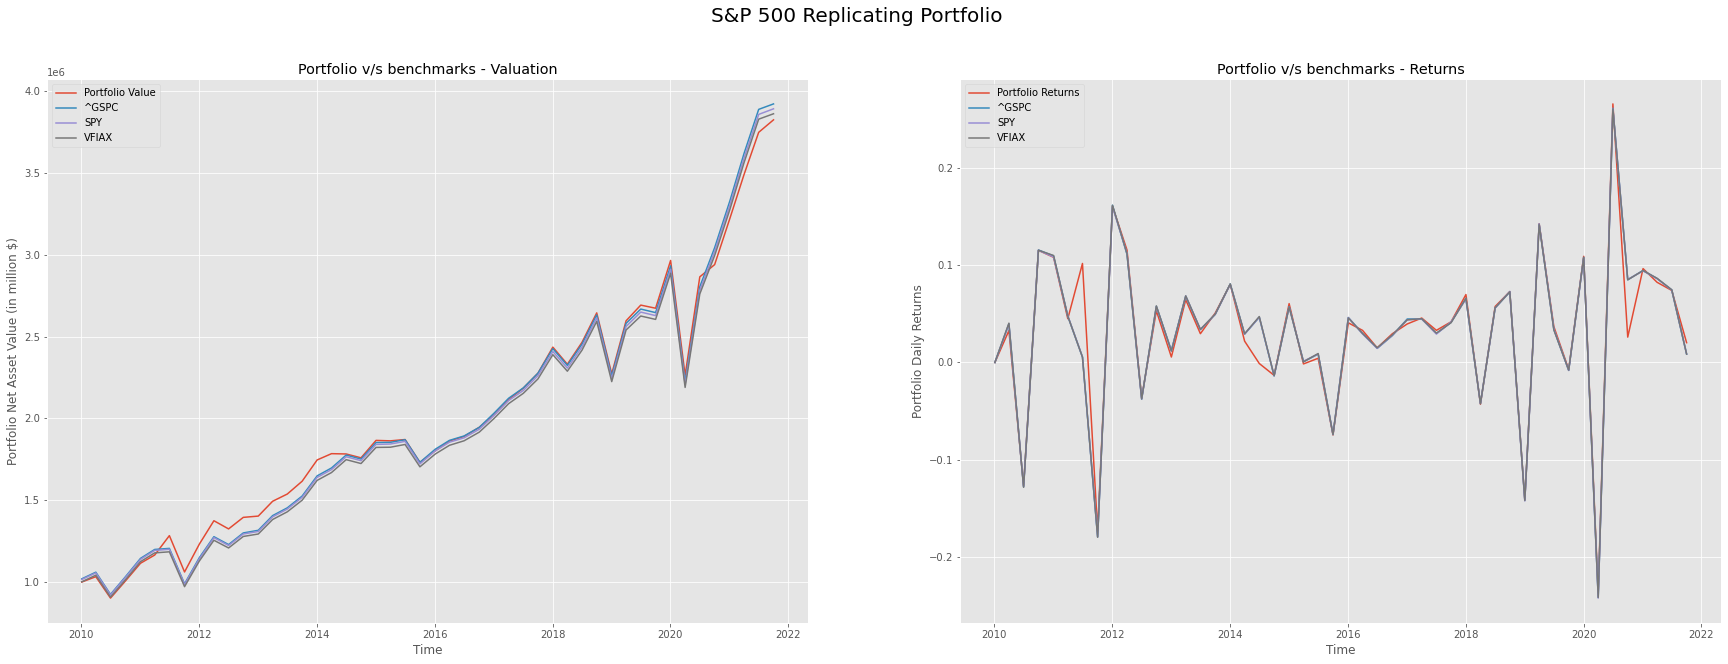

In [19]:
fig, ax = plt.subplots(1,2, sharex= False, sharey=False)
fig.set_size_inches(30, 10,  forward=True)

ax[0].plot(portfolio_val)
ax[0].plot(data["^GSPC"]*900)
ax[0].plot(data["SPY"]*8961.3)
ax[0].plot(data["VFIAX"]*9600)
ax[0].legend(["Portfolio Value","^GSPC","SPY","VFIAX"])
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Portfolio Net Asset Value (in million $)")
ax[0].set_title("Portfolio v/s benchmarks - Valuation")

ax[1].plot(portfolio_returns)
ax[1].plot(baseline_return["^GSPC"])
ax[1].plot(baseline_return["SPY"])
ax[1].plot(baseline_return["VFIAX"])
ax[1].legend(["Portfolio Returns","^GSPC","SPY","VFIAX"])
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Portfolio Daily Returns")
ax[1].set_title("Portfolio v/s benchmarks - Returns")

fig.suptitle('S&P 500 Replicating Portfolio',fontsize=20)

In [20]:
tracking_error_spy = baseline_return.apply(lambda x: (tracking_error(portfolio_returns,x)))
for index, value in tracking_error_spy.iteritems():
    print("Tracking error between our portfolio and {target} is {std}%".format(target = index, std = str(round(value,5)*100)))

Tracking error between our portfolio and SPY is 1.823%
Tracking error between our portfolio and VFIAX is 1.828%
Tracking error between our portfolio and ^GSPC is 1.825%


# DJIA Replicating Portfolio

## Fetch DJIA Index Constituent Data

In [4]:
# # Create webdriver object
# webDriverLocation = '../../utils/chromedriver'
# driver = webdriver.Chrome(executable_path = webDriverLocation)

# # Get the website
# url = "https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average"
# driver.get(url)

# def get_text(x):
#     return x.text

In [5]:
# xpath = '//*[@id="constituents"]/tbody/tr/td[2]/a'
# djia_ticker_set = set()
# for item in driver.find_elements_by_xpath(xpath=xpath):
#     djia_ticker_set.add(get_text(item))
# print(len(djia_ticker_set))
# driver.close()
# # djia_ticker_set

In [6]:
# with open('./data/djia_ticker.txt', 'w') as f:
#     for item in djia_ticker_set:
#         f.write("%s\n" % item)

## Read DJIA Index Constituent Data

In [7]:
djia_ticker_set = set()
with open('./data/djia_ticker.txt') as f:
    djia_ticker_set = f.readlines()
    djia_ticker_set = {x.strip() for x in djia_ticker_set}
print(len(djia_ticker_set))

30


Fetch data from WRDS using the  list

***

## Read Daily Stock data from WRDS

### Desciption:

- GVKEY: Company Code ?
- IID  : Issue ID - Dividents ?
- DATADATE: Date
- TIC: Company Ticker
- CUSIP: Company CUSIP Code
- CONM : Company Name
- CSHOC : Shares Outstanding
- CSHTRD : Trading Volume
- PRCCD : Price Close Daily
- PRCHD : Price High Daily
- PRCLD : Price Low Daily
- PRCOD : Price Open Daily
- TRFD  : Total Return Factor Daily
- EXCHG : Stock Exchange Code
- BUSDESC : S&P Business Description
- GGROUP : GIC Groups
- GIND : GIC Industries
- GSECTOR : GIC Sector
- GSUBIND : GIC Sub-Industry

**Looking at stocks since 01 Jan 2010**

In [8]:
complete_df = pd.read_csv("./data/djia_dataset.csv"
                    ,low_memory= False)

djia_data = complete_df[["datadate","tic","prccd"]].copy()\
                                                .sort_values(by= "datadate")\
                                                .rename({'prccd':'close'}, axis = 1).\
                                                reset_index(drop=True)
djia_data["datadate"] = pd.to_datetime(djia_data["datadate"])
djia_data = djia_data[djia_data["datadate"] >= pd.to_datetime("01-01-2010")].sort_values(by="datadate")
djia_data = djia_data[djia_data["tic"].apply(lambda x: (x in djia_ticker_set))]

print("Number of unique tickers:",len(djia_data.tic.value_counts()))
print("Dimensions: ",djia_data.shape)
print("NULL count:\n",djia_data.isna().sum())
djia_data

Number of unique tickers: 30
Dimensions:  (86573, 3)
NULL count:
 datadate    0
tic         0
close       0
dtype: int64


,datadate,tic,close
521,2010-01-04,MCD,62.78
511,2010-01-04,CSCO,24.69
512,2010-01-04,IBM,132.45
513,2010-01-04,V,88.14
514,2010-01-04,UNH,31.53
...,...,...,...
85713,2021-10-08,AAPL,142.90
85714,2021-10-08,IBM,143.22
85715,2021-10-08,AXP,175.15
85716,2021-10-08,MCD,247.70


In [9]:
djia_data = djia_data.set_index(["datadate","tic"])
djia_data

close
datadate   tic         
2010-01-04 MCD    62.78
           CSCO   24.69
           IBM   132.45
           V      88.14
           UNH    31.53
...                 ...
2021-10-08 AAPL  142.90
           IBM   143.22
           AXP   175.15
           MCD   247.70
           DOW    58.71

[86573 rows x 1 columns]

In [39]:
market_calendar_dates = sorted(list(set(map(lambda x: x[0],djia_data.index.values))))
market_calendar_dates[0:5]

[Timestamp('2010-01-04 00:00:00'),
 Timestamp('2010-01-05 00:00:00'),
 Timestamp('2010-01-06 00:00:00'),
 Timestamp('2010-01-07 00:00:00'),
 Timestamp('2010-01-08 00:00:00')]

## Executing Portfolio

In [11]:
djia_portfolio = Portfolio(target="DJIA",
                        tickerlist= list(djia_ticker_set), investment= 1000000,
                        rebalance=4, reconstitute=12)

djia_portfolio.echo()

Target Index: DJIA
Starting Investment: 1000000
Current Investment: 1000000
Net Returns: 0.0 %
Constituent Indices: AMGN, BA, IBM, MMM, CVX ...
Constituent Weights: AMGN    1
BA      1
IBM     1
MMM     1
CVX     1
dtype: int64


In [12]:
portfolio_val = pd.Series([], dtype=float)
portfolio_returns = pd.Series([], dtype=float)

for dates in market_calendar_dates:
    tmpdf = djia_data.loc[dates,:]
    # if djia_portfolio.isUpdateAllowed(dates,mode="reconstitute"):
    #     continue
    if djia_portfolio.isUpdateAllowed(dates):
        # print("Rebalancing in: "+dates.strftime("%d-%b-%Y"))
        djia_portfolio.rebalance(date= dates, price = tmpdf)
        portfolio_val[dates] = djia_portfolio.current_nav
        portfolio_returns[dates] = djia_portfolio.get_returns()
        # print(djia_portfolio.current_nav)

In [13]:
print("Net return since start: ",djia_portfolio.net_return()*100,"%")

Net return since start:  180.81942111867988 %


In [14]:
from scipy.stats.mstats import gmean
print("daily return: ",(gmean(portfolio_returns+1)-1)*100,"%")

daily return:  2.174431996091597 %


## DJIA Index, ETF and Mutual Fund(Not yet available)

In [28]:
# djia_index = pd.read_csv("./data/djia_index.csv")
# djia_index["datadate"] = pd.to_datetime(djia_index["datadate"])
# djia_index = djia_index.set_index(["datadate"])
# djia_index = pd.Series(djia_index["close"])

# djia_etf = pd.read_csv("./data/djia_etf.csv")
# djia_etf["datadate"] = pd.to_datetime(djia_etf["datadate"], format='%Y%m%d')
# djia_etf = djia_etf.set_index(["datadate"])
# djia_etf = pd.Series(djia_etf["close"])

# djia_mutual = pd.read_csv("./data/djia_mutual.csv")
# djia_mutual["datadate"] = pd.to_datetime(djia_mutual["datadate"])
# djia_mutual = djia_mutual.set_index(["datadate"])
# djia_mutual = pd.Series(djia_mutual["close"])

In [105]:
# data = pd.DataFrame(index = djia_mutual.index)
# data["^DJI"] = djia_index
# data["DIA"] = djia_etf
# data["VTSMX"] = djia_mutual
# data = data.loc[portfolio_val.index[4:-4]]
# data.head()

,^DJI,DIA,VTSMX
datadate,,,
2011-01-03,11670.75000,116.41,26.430233
2011-04-01,12376.71973,123.46,27.913061
2011-07-01,12582.76953,125.58,28.173460
2011-10-03,10655.29980,106.36,22.760691
2012-01-03,12397.37988,123.63,26.763987


In [110]:
data = yf.download("^DJI DIA VTSMX", start="2010-01-01", end="2021-10-07")
data = data["Close"].loc[portfolio_returns.index]
data.head()

[*********************100%***********************]  3 of 3 completed


,DIA,VTSMX,^DJI
Date,,,
2010-01-04,105.660004,27.910000,10583.959961
2010-04-01,109.279999,29.209999,10927.070312
2010-07-01,97.339996,25.490000,9732.530273
2010-10-01,108.320000,28.540001,10829.679688
2011-01-03,116.410004,31.940001,11670.750000


In [111]:
baseline_return = data.apply(daily_returns).fillna(0)
baseline_return.head()

,DIA,VTSMX,^DJI
Date,,,
2010-01-04,0.000000,0.000000,0.000000
2010-04-01,0.034261,0.046578,0.032418
2010-07-01,-0.109261,-0.127354,-0.109319
2010-10-01,0.112801,0.119655,0.112730
2011-01-03,0.074686,0.119131,0.077663


## Plot

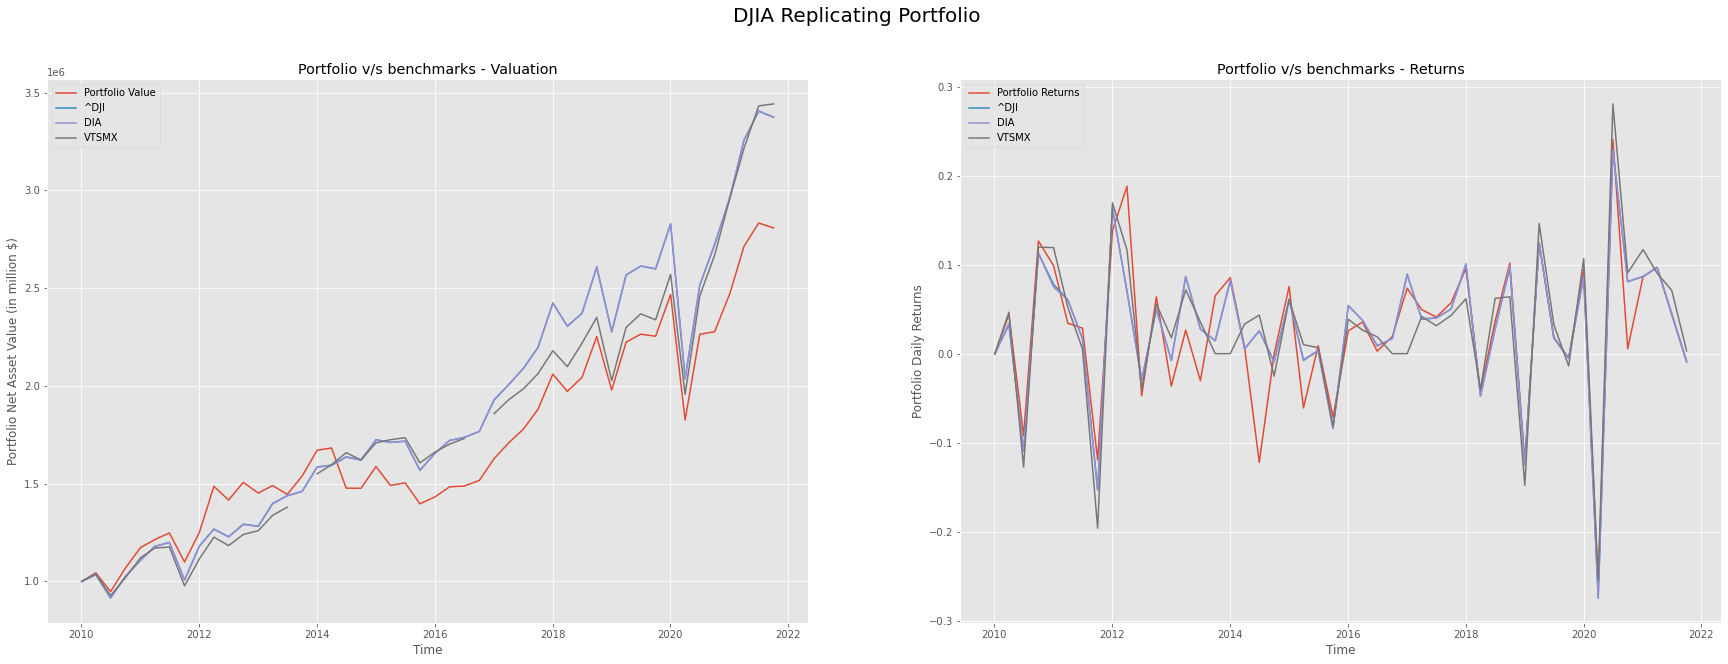

In [112]:
fig, ax = plt.subplots(1,2, sharex= False, sharey=False)
fig.set_size_inches(30, 10,  forward=True)

# ax[0].plot(portfolio_val[4:-4])
ax[0].plot(portfolio_val)
ax[0].plot((data["^DJI"]-584)*100)
ax[0].plot((data["DIA"]-5.66)*10000)
ax[0].plot(data["VTSMX"]*30000 + 162700)
ax[0].legend(["Portfolio Value","^DJI","DIA","VTSMX"])
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Portfolio Net Asset Value (in million $)")
ax[0].set_title("Portfolio v/s benchmarks - Valuation")
# ax[0].set_xlim(pd.to_datetime("31-12-2010"), pd.to_datetime("31-12-2020"))

# ax[1].plot(portfolio_returns[4:-4])
ax[1].plot(portfolio_returns)
ax[1].plot(baseline_return["^DJI"])
ax[1].plot(baseline_return["DIA"])
ax[1].plot(baseline_return["VTSMX"])
ax[1].legend(["Portfolio Returns","^DJI","DIA","VTSMX"])
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Portfolio Daily Returns")
ax[1].set_title("Portfolio v/s benchmarks - Returns")
# ax[1].set_xlim(pd.to_datetime("31-12-2010"), pd.to_datetime("31-12-2020"))
fig.suptitle('DJIA Replicating Portfolio',fontsize=20);

In [113]:
tracking_error_djia = baseline_return.apply(lambda x: (tracking_error(portfolio_returns,x)))
for index, value in tracking_error_djia.iteritems():
    print("Tracking error between our portfolio and {target} is {std}%".format(target = index, std = str(round(value,5)*100)))

Tracking error between our portfolio and DIA is 3.599%
Tracking error between our portfolio and VTSMX is 4.41%
Tracking error between our portfolio and ^DJI is 3.596%


***
***